## SULTAN QABOOS UNIVERSITY
## DEPARTMENT OF COMPUTER SCIENCE
# MACHINE LEARNING (COMP4603)
## CLASSIFICATION Project (Customer Segmentation classification )

### MARYA AL RAHBI (131247)
### Razan Dweib (131997)

In [2]:

import warnings

import pandas as pd

from sklearn import preprocessing

from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import SequentialFeatureSelector, VarianceThreshold, SelectKBest, chi2 ,RFE

from sklearn.neighbors import KNeighborsClassifier


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectFromModel

## Dataset

data source: https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation?resource=download

uploaded by : Abishek Sudarshan 

In [3]:
warnings.filterwarnings("ignore")

# read file
train_file='train.csv'

df= pd.read_csv(train_file)

### Explore dataset :

Data information :

 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB
************************************************************


Dimentions of train data is  (8068, 11)
************************************************************


First five columns of data : 


       ID  

<AxesSubplot:xlabel='Segmentation', ylabel='count'>

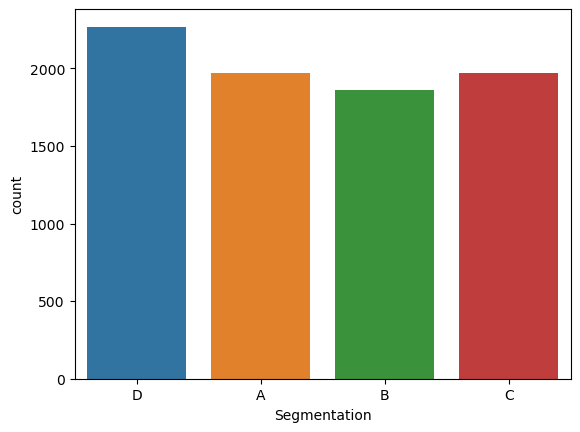

In [12]:
# info 

print ("Data information :\n\n ")
df.info()

print("*"*60)
print("\n\nDimentions of train data is ", df.shape )

print("*"*60)
print("\n\nFirst five columns of data : \n\n")
print(df.head() )

print("\n")
print("*"*60)
print("Data Describtion :")
# description
print(df.describe())
print("*"*60)
# labels count
sns.countplot(df['Segmentation'])

- From label plot :
    - D label has the maximum number .
    - A, B and C are similar .
    - There is no big difference between the classes .

### Data preprocessing

Noticed that :

    1. The data contains 11 feature and  8068 samples
    2. All features are String except the age , work experience and    family size . ( Encoding is needed ).
    3. Different scale numbers ( Scaler is needed)
    4. Null values (Remove the null values)
    

#### Missing values handling

Null report Before Missing data handling :

 
                 missing_Val
Work_Experience          829
Family_Size              335
Ever_Married             140
Profession               124
Graduated                 78
Var_1                     76
ID                         0
Gender                     0
Age                        0
Spending_Score             0
Segmentation               0

 After Missing data handling : 
 
                 missing_Val
ID                         0
Gender                     0
Ever_Married               0
Age                        0
Graduated                  0
Profession                 0
Work_Experience            0
Spending_Score             0
Family_Size                0
Var_1                      0
Segmentation               0


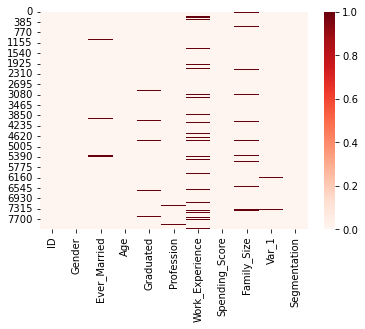

In [55]:

# location of null values 
sns.heatmap(df.isna(), cmap=plt.cm.Reds)

def nullReport():
    
    '''
    This function to display the null report values.
    
    '''

    # state the missing values
    
    missing_values=df.isna().sum()
   
    
    data={'missing_Val' : missing_values}
    
    data2=pd.DataFrame(data)
    
    data3=data2.sort_values(by='missing_Val', ascending=False )
    
    print(data3)



#1. Missing data

print("Null report Before Missing data handling :\n\n ")


nullReport()

# Remove null values from (work experience) feature :

work_mean=int(df['Work_Experience'].mean())

df['Work_Experience'].fillna(work_mean ,  inplace=True )




# Remove null values from (family size) feature  :
    
familySize_mean=int(df['Family_Size'].mean())
df["Family_Size"].fillna(familySize_mean, inplace=True)


# Remove null values from (Married) feature ( replace with the most frequence appearing )

df["Ever_Married"].fillna(df["Ever_Married"].mode().iloc[0], inplace=True)


# Remove null values from (profession) feature 

df["Profession"].fillna(df["Profession"].mode().iloc[0], inplace=True)

#Remove null values from (Graduated) feature 

df["Graduated"].fillna(df["Graduated"].mode().iloc[0], inplace=True)

# Remove null values from (Var_1) feature

df["Var_1"].fillna(df["Var_1"].mode().iloc[0], inplace=True)

print("\n After Missing data handling : \n ")

nullReport()


### Encoding

In [56]:
# 2. Encoding 

#marriage encoding

label_encoder=preprocessing.LabelEncoder()

df['Ever_Married']=label_encoder.fit_transform(df['Ever_Married'])


# graduation encoding

df['Graduated']=label_encoder.fit_transform(df['Graduated'])

# gendor encoding 


df["Gender"]=label_encoder.fit_transform(df['Gender'])


# spending score

df["Spending_Score"]=label_encoder.fit_transform(df["Spending_Score"])

# profession encoding 

df["Profession"]=label_encoder.fit_transform(df["Profession"])

# var1 encoding

df["Var_1"]=label_encoder.fit_transform(df["Var_1"])

# Segmentation encoding 
df["Segmentation"]=label_encoder.fit_transform(df["Segmentation"])


# define X and Y

X=df.iloc[: , 1:-1].values # drop the id feature
Y=df.iloc[:, -1].values

# 3. scalling

scaler=MinMaxScaler()
X=scaler.fit_transform(X)




### Feature correlation 
To take the subset of relevent data.

<AxesSubplot:>

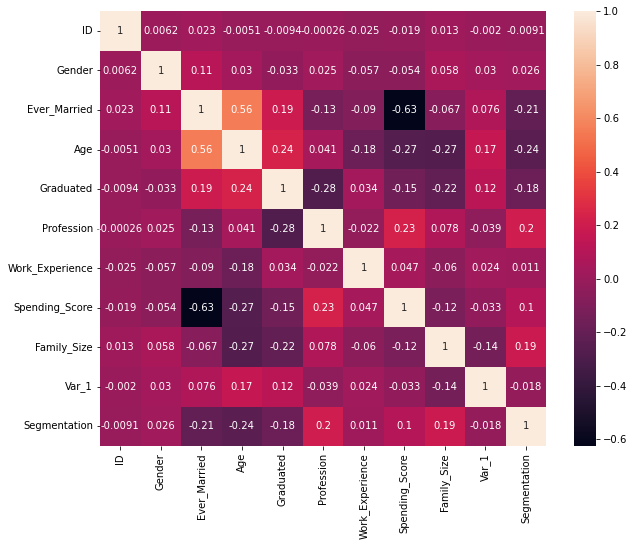

In [57]:
corrmat = df.corr()
plt.subplots(figsize=(10,8))
sns.heatmap(corrmat, annot=True)

We can notice that:
 - The correlation between features is not very high, that refers to good correlation and no need to drop ( no correlated features) .
 - The correlation here is between numeric features only.
 - We will use Different function to choose best features among all using :
     1. Sequential function
     2. Variance function
     3. Select best K function
     4. Recursive Feature Elimination 
     5. Select from model

In [58]:
# feature selection(sfs) 

def sfs(classifier , n = 5):
    sfs=SequentialFeatureSelector(classifier,n_features_to_select=n)
    sfs.fit(X,Y)
    x_sfs=sfs.transform(X)
    return x_sfs


def sfs_backward(classifier , n = 5):
    sfs=SequentialFeatureSelector(classifier,n_features_to_select=5 ,direction = 'backward')
    sfs.fit(X,Y)
    x_sfs=sfs.transform(X)
    return x_sfs


def varianceThresholdFnc():
    selector=VarianceThreshold()

    x_selector=selector.fit_transform(X)
    return x_selector


def selectKbest_fnc():
    selector=SelectKBest(score_func=chi2, k=3)
    selector_x=selector.fit_transform(X,Y)
    return selector_x
    
def RFE_fnc(classifier):
    selector=RFE(classifier, n_features_to_select=3, step=1)
    x_selector=selector.fit_transform(X,Y)
    return x_selector



def SelectFromModel_fnc(classifier):
    selector = SelectFromModel(estimator=classifier)
    x_selector = selector.fit_transform(X,Y)
    return x_selector



## Classification Model

In [59]:
from sklearn.metrics import classification_report

def DecisionTree(obj,xData):
    
    x_train,x_test,y_train,y_test=train_test_split(xData,Y, stratify=Y)
    alpha_range=range(0,10)
    criterion_opt = ['gini', 'entropy']
    max_depth_opt = [2,4,6,8,10,12]
    
    clf=obj
    param_grid=dict(ccp_alpha=alpha_range, criterion=criterion_opt,max_depth=max_depth_opt)
    grid=GridSearchCV(clf,param_grid,cv=5, scoring='accuracy', return_train_score=False, verbose=1)
    grid_val=grid.fit(x_train,y_train)
    best_score=grid_val.best_score_
    y_predict=grid.predict(x_test)
    acc=accuracy_score(y_test,y_predict)
    
    # classification report 

    print(classification_report(y_test,y_predict))
    print("=="*30)

    return acc

In [60]:
def KNN(obj,xData):
    
    x_train,x_test,y_train,y_test=train_test_split(xData,Y)
    k_range = list(range(1, 31))
    param_grid_knn = dict(n_neighbors=k_range)
    grid_knn = GridSearchCV(obj, param_grid_knn, cv=5, scoring='accuracy')
    # fit in the data 
    grid_knn= grid_knn.fit(x_train, y_train)
    #best_k= grid_knn_mm.best_params_['n_neighbors']
    score = grid_knn.best_score_
    y_predict=grid_knn.predict(x_test)
    acc=accuracy_score(y_test,y_predict)
    

    print(classification_report(y_test,y_predict))
    print("=="*30)
    
    return acc

In [61]:
def LR(obj,xData):
    
    x_train,x_test,y_train,y_test=train_test_split(xData,Y)
    penalty_options=['l1','l2']
    c_val=[0.05 , 0.1 , 0.15 , 0.2 , 0.25 , 0.3 , 0.35 , 0.4 , 0.45  ,0.5 , 0.55 , 0.65 , 0.7 , 0.75 , 0.8 , 0.85 , 0.9 , 0.95 ,1]

    parameters=dict(penalty=penalty_options, C=c_val)
    
    grid_lgr = GridSearchCV(obj, parameters, scoring='accuracy',cv=5)
    
    # fit in the data 
    grid_lgr = grid_lgr.fit(x_train, y_train)  
    
    score = grid_lgr.best_score_
    
    y_predict=grid_lgr.predict(x_test)
    acc=accuracy_score(y_test,y_predict)
    
    print(classification_report(y_test,y_predict))
    print("=="*30)
    
    
    return acc

## Results (Decision Tree )

In [62]:
# Dictionary for accuracy 
dict_acc={}

# with no FS 

Accuracy_D=[]

print("Confusion Matrix with no feature selection : \n " )
clf=DecisionTreeClassifier()  
acc_no_FS=DecisionTree(clf,X)

Accuracy_D.append(acc_no_FS)

Confusion Matrix with no feature selection : 
 
Fitting 5 folds for each of 120 candidates, totalling 600 fits
              precision    recall  f1-score   support

           0       0.41      0.58      0.48       493
           1       0.43      0.27      0.33       465
           2       0.59      0.57      0.58       492
           3       0.65      0.65      0.65       567

    accuracy                           0.52      2017
   macro avg       0.52      0.52      0.51      2017
weighted avg       0.53      0.52      0.52      2017



Decision Tree with 2 feature selection
Fitting 5 folds for each of 120 candidates, totalling 600 fits
              precision    recall  f1-score   support

           0       0.37      0.47      0.42       493
           1       0.31      0.12      0.17       465
           2       0.50      0.57      0.53       492
           3       0.60      0.69      0.64       567

    accuracy                           0.48      2017
   macro avg       0.45      0.46      0.44      2017
weighted avg       0.45      0.48      0.45      2017

Decision Tree with 3 feature selection
Fitting 5 folds for each of 120 candidates, totalling 600 fits
              precision    recall  f1-score   support

           0       0.40      0.41      0.40       493
           1       0.35      0.36      0.35       465
           2       0.56      0.54      0.55       492
           3       0.63      0.63      0.63       567

    accuracy                           0.49      2017
   macro avg       0.49      0.48  

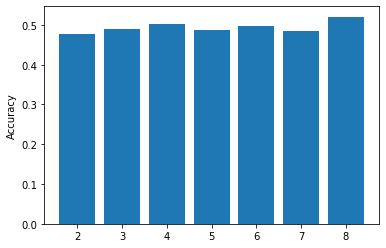

In [63]:
 # This loop to return the best number of features in Sequential selection of Decision Tree
N = list(range(2,9))
acc_N = list() 
for n in N:
    print(f"Decision Tree with {n} feature selection")
    x_seq_n=sfs(clf,n)
    acc_sfs_n=DecisionTree(clf, x_seq_n)
    acc_N.append(acc_sfs_n)

    
# plot the result
plt.bar(N,acc_N)
plt.ylabel('Accuracy')
plt.show()

#### Note 
- Notic that , the accuracy is low before feature selection.
So, we applied different feature selection to increase the accuracy rate

- From the graph :
 Number of feature = 8 , has the maximum accuracy, so we will use it in next SFS.

Confusion Matrix with sequential feature selection forward :

 
Fitting 5 folds for each of 120 candidates, totalling 600 fits
              precision    recall  f1-score   support

           0       0.41      0.52      0.46       493
           1       0.38      0.27      0.32       464
           2       0.58      0.55      0.56       493
           3       0.65      0.67      0.66       567

    accuracy                           0.51      2017
   macro avg       0.50      0.50      0.50      2017
weighted avg       0.51      0.51      0.51      2017

Confusion Matrix with sequential feature selection backward :

 
Fitting 5 folds for each of 120 candidates, totalling 600 fits
              precision    recall  f1-score   support

           0       0.39      0.42      0.41       493
           1       0.36      0.28      0.31       465
           2       0.56      0.58      0.57       492
           3       0.63      0.69      0.66       567

    accuracy                          

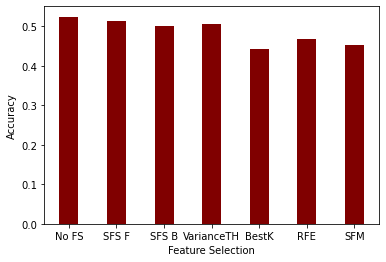

In [64]:

# after Sequential feature selection forward

print("Confusion Matrix with sequential feature selection forward :\n\n ")
x_seq=sfs(clf,8)
acc_sfs=DecisionTree(clf, x_seq)
Accuracy_D.append(acc_sfs)

# after Sequential feature selection backward

print("Confusion Matrix with sequential feature selection backward :\n\n ")
x_seq=sfs_backward(clf,8)
acc_sfs_backward=DecisionTree(clf, x_seq)
Accuracy_D.append(acc_sfs_backward)

# after variance Threshold selector

print("Confusion Matrix report after variance Threshold :\n\n ")

x_varianceTh=varianceThresholdFnc()
acc_variance=DecisionTree(clf, x_varianceTh)
 
Accuracy_D.append(acc_variance)

# After best K: 
print("Confusion Matrix after Best K selector is : \n\n ")
x_bestK=selectKbest_fnc()
acc_bestK=DecisionTree(clf, x_bestK)

Accuracy_D.append(acc_bestK)

# After RFE :
print("Confusion Matrix after RFE selector is : \n\n")
x_RFE=RFE_fnc(clf)
acc_RFE=DecisionTree(clf,x_RFE)
Accuracy_D.append(acc_RFE)


# After Select From Model :
print("Confusion Matrix after Select From Model selector is : \n\n")
x_SFM=SelectFromModel_fnc(clf)
acc_SFM=DecisionTree(clf,x_SFM)
Accuracy_D.append(acc_SFM)

# Plot the bar plto: 

x_Dtree=["No FS", "SFS F" ,"SFS B","VarianceTH","BestK","RFE", "SFM"]

# Bar plot 
plt.bar(x_Dtree,Accuracy_D, color='maroon', width=0.4)
plt.xlabel("Feature Selection")
plt.ylabel("Accuracy")

# maximum accuracy 
maximum_acc_Dtree=max(Accuracy_D)
dict_acc['Decision_tree']=maximum_acc_Dtree

From the Bar chart :
- All feature selection have similar accuracy ( not exceeding 52%)
- Best K , has the least accuracy
- Variance Threshold and sequential feature selection forward have the maximum accuracy from feature selection method.
- But without the feature selection we get the best accuracy

### Results( KNN): 


In [65]:
# No feature selection :

Accuracy_knn=[]
print("Confusion matrix of KNN with no feature selection :\n\n " )
clf2=KNeighborsClassifier()
acc_no_FS2=KNN(clf2, X)

Accuracy_knn.append(acc_no_FS2)

Confusion matrix of KNN with no feature selection :

 
              precision    recall  f1-score   support

           0       0.41      0.42      0.42       498
           1       0.35      0.29      0.32       454
           2       0.56      0.59      0.57       501
           3       0.64      0.68      0.66       564

    accuracy                           0.51      2017
   macro avg       0.49      0.50      0.49      2017
weighted avg       0.50      0.51      0.50      2017



knn with 2 feature selection
              precision    recall  f1-score   support

           0       0.37      0.33      0.35       491
           1       0.31      0.31      0.31       438
           2       0.46      0.48      0.47       509
           3       0.62      0.66      0.64       579

    accuracy                           0.46      2017
   macro avg       0.44      0.44      0.44      2017
weighted avg       0.45      0.46      0.45      2017

knn with 3 feature selection
              precision    recall  f1-score   support

           0       0.43      0.47      0.45       506
           1       0.39      0.34      0.37       471
           2       0.51      0.48      0.50       463
           3       0.63      0.68      0.66       577

    accuracy                           0.50      2017
   macro avg       0.49      0.49      0.49      2017
weighted avg       0.50      0.50      0.50      2017

knn with 4 feature selection
              precision    recall  f1-score

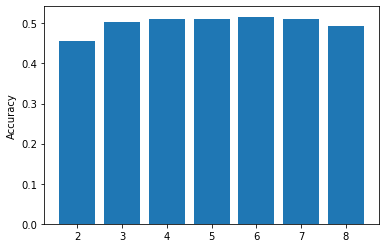

In [66]:
 # This loop to return the best number of features in Sequential selection
N = list(range(2,9))
acc_N = list() 
for n in N:
    print(f"knn with {n} feature selection")
    x_seq_n=sfs(clf2,n)
    acc_sfs_n=KNN(clf2, x_seq_n)
    acc_N.append(acc_sfs_n)

    
# plot the result
plt.bar(N,acc_N)
plt.ylabel('Accuracy')
plt.show()

From the graph :
- Number of feature = 6 , has the maximum accuracy, so we will use it in next SFS.

Confusion matrix after sequential feature selection (KNN): 

 
              precision    recall  f1-score   support

           0       0.42      0.47      0.45       475
           1       0.41      0.31      0.36       458
           2       0.56      0.52      0.54       505
           3       0.63      0.72      0.67       579

    accuracy                           0.52      2017
   macro avg       0.50      0.51      0.50      2017
weighted avg       0.51      0.52      0.51      2017

Confusion matrix after sequential feature selection (KNN): 

 
              precision    recall  f1-score   support

           0       0.43      0.43      0.43       513
           1       0.34      0.32      0.33       429
           2       0.56      0.52      0.54       489
           3       0.65      0.71      0.68       586

    accuracy                           0.51      2017
   macro avg       0.50      0.50      0.50      2017
weighted avg       0.51      0.51      0.51      2017

Conf

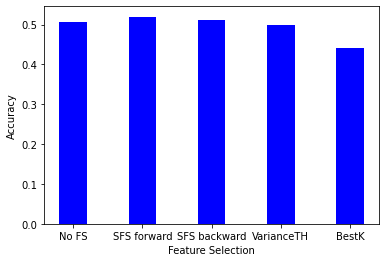

In [67]:

# sfs in knn: 

print("Confusion matrix after sequential feature selection (KNN): \n\n ")
x_seq2=sfs(clf2,6)
acc_sfs2=KNN(clf2, x_seq2)

Accuracy_knn.append(acc_sfs2)


print("Confusion matrix after sequential feature selection (KNN): \n\n ")
x_seq2_backward=sfs_backward(clf2, 6)
acc_sfs2__backward=KNN(clf2, x_seq2_backward)

Accuracy_knn.append(acc_sfs2__backward)

# variance Threshold in knn:
print("Confusion matrix after variance Threshold (knn):\n\n ")
x_varianceTh2=varianceThresholdFnc()
acc_variance2=KNN(clf2, x_varianceTh2)

Accuracy_knn.append(acc_variance2)

# select best K in KNN:
print("Confusion matrix after Best K selector is : \n\n")
x_bestK2=selectKbest_fnc()
acc_bestK2=KNN(clf2, x_bestK2)

Accuracy_knn.append(acc_bestK2)


# RFE in KNN :
# knn does not suppur this feature selection 

x_Ktree=["No FS", "SFS forward" ,"SFS backward","VarianceTH","BestK" ] 

# Bar plot 
plt.bar(x_Ktree,Accuracy_knn, color='blue', width=0.4)
plt.xlabel("Feature Selection")
plt.ylabel("Accuracy")


# maximum accuracy 
maximum_acc_knn=max(Accuracy_knn)
dict_acc['KNN']=maximum_acc_knn

### From the Bar chart:
  - Best K feature selection has the least accuracy 
  -  Other feature seletion , have simliar accuracy (not greater than 50%)
  - Accuracy before and after feature slection is same, so in this case feature 
    selection is not important. ( That is becuase , feature selection is more important 
    in neural network algorithms, and KNN not of them . It is based in distance between datapoints,
     therefore accuracy did not change after feature selection)

### Results (Logistic Regrission):

In [68]:
# with no FS 

Accuracy_LRR=[]

print("Confusion Matrix with no feature selection : \n " )
clf3=LogisticRegression()
acc_no_FS3=LR(clf3, X)
Accuracy_LRR.append(acc_no_FS3)


Confusion Matrix with no feature selection : 
 
              precision    recall  f1-score   support

           0       0.44      0.39      0.41       522
           1       0.31      0.18      0.23       420
           2       0.51      0.57      0.54       509
           3       0.61      0.80      0.69       566

    accuracy                           0.51      2017
   macro avg       0.47      0.48      0.47      2017
weighted avg       0.48      0.51      0.48      2017



LR with 2 feature selection
              precision    recall  f1-score   support

           0       0.30      0.43      0.36       487
           1       0.34      0.10      0.15       455
           2       0.53      0.56      0.54       520
           3       0.52      0.61      0.56       555

    accuracy                           0.44      2017
   macro avg       0.42      0.42      0.40      2017
weighted avg       0.43      0.44      0.41      2017

LR with 3 feature selection
              precision    recall  f1-score   support

           0       0.38      0.37      0.38       519
           1       0.25      0.04      0.07       460
           2       0.50      0.60      0.54       508
           3       0.49      0.76      0.60       530

    accuracy                           0.46      2017
   macro avg       0.40      0.44      0.40      2017
weighted avg       0.41      0.46      0.41      2017

LR with 4 feature selection
              precision    recall  f1-score   

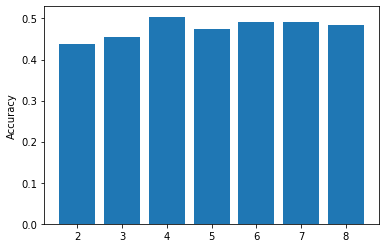

In [69]:
 # This loop to return the best number of features in Sequential selection using LR
N = list(range(2,9))
acc_N = list() 
for n in N:
    print(f"LR with {n} feature selection")
    x_seq_n=sfs(clf3,n)
    acc_sfs_n=LR(clf3, x_seq_n)
    acc_N.append(acc_sfs_n)

    
# plot the result
plt.bar(N,acc_N)
plt.ylabel('Accuracy')
plt.show()

From the graph :
- Number of feature = 4 , has the maximum accuracy, so we will use it in next SFS.

Confusion matrix after sequential feature selection forward: 


              precision    recall  f1-score   support

           0       0.36      0.45      0.40       474
           1       0.37      0.04      0.08       481
           2       0.50      0.65      0.57       515
           3       0.59      0.75      0.66       547

    accuracy                           0.48      2017
   macro avg       0.45      0.47      0.43      2017
weighted avg       0.46      0.48      0.44      2017

Confusion matrix after sequential feature selection backward : 


              precision    recall  f1-score   support

           0       0.42      0.44      0.43       533
           1       0.34      0.11      0.17       438
           2       0.51      0.63      0.57       481
           3       0.57      0.73      0.64       565

    accuracy                           0.50      2017
   macro avg       0.46      0.48      0.45      2017
weighted avg       0.47      0.50      0.47      2017



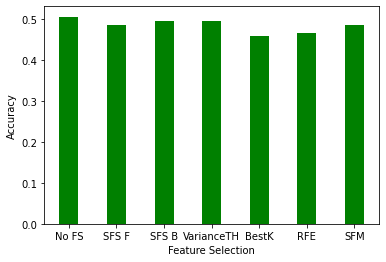

In [70]:
# with SFS 

print("Confusion matrix after sequential feature selection forward: \n\n")

acc_sfs3=sfs(clf3,4)
x_seq3=LR(clf3,acc_sfs3)
Accuracy_LRR.append(x_seq3)

print("Confusion matrix after sequential feature selection backward : \n\n")

acc_sfs3=sfs(clf3,4)
x_seq3=LR(clf3,acc_sfs3)
Accuracy_LRR.append(x_seq3)

# with variance Threshold 

print("Confusion matrix after variance Threshold : \n\n ")
x_varianceTh3=varianceThresholdFnc()
acc_variance3=LR(clf3, x_varianceTh3)

Accuracy_LRR.append(acc_variance3)

# Best K selection 
print("Confusion matrix after Best K selector is : \n\n")

x_bestK3=selectKbest_fnc()
acc_bestK3=LR(clf3, x_bestK3)

Accuracy_LRR.append(acc_bestK3)

print("Confusion matrix after RFE selector is :\n\n ")
x_RFE3=RFE_fnc(clf3)
acc_RFE3=LR(clf3,x_RFE3)

Accuracy_LRR.append(acc_RFE3)


# After Select From Model :
print("Confusion Matrix after Select From Model selector is : \n\n")
x_SFM3=SelectFromModel_fnc(clf3)
acc_SFM3=LR(clf3,x_SFM3)
Accuracy_LRR.append(acc_SFM3)


# Bar chart
x_Ltree=["No FS", "SFS F" ,"SFS B","VarianceTH","BestK", "RFE","SFM"]

# Bar plot 
plt.bar(x_Ltree,Accuracy_LRR, color='Green', width=0.4)
plt.xlabel("Feature Selection")
plt.ylabel("Accuracy")

# maximum accuracy 
maximum_acc_LR=max(Accuracy_LRR)
dict_acc['Logistic Regrission'] = maximum_acc_LR

From the Bar chart:
- The highest accuracy is in Variance Threshold
- Best k has least accuracy 

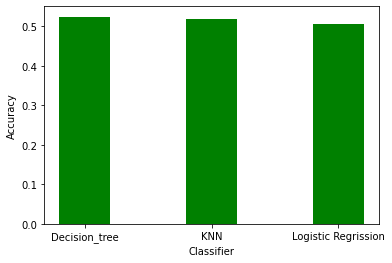

Best Accuracy in Decision_tree =  0.5245
Best Accuracy in KNN =  0.5196
Best Accuracy in Logistic Regrission =  0.5062


In [73]:
# Final report 

# Bar chart ( X> Classifier , y > accuracy )
# Bar plot 
Classifier = list(dict_acc.keys())
accuracy = list(dict_acc.values())
plt.bar(Classifier,accuracy, color='Green', width=0.4)
plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.show()

# Best Accuracy in Decision tree=... 
for cls_n in Classifier:
    print(f"Best Accuracy in {cls_n} =  {round(dict_acc[cls_n],4)}")


## from the bar we can note that :
The best classifier is Decision tree with Acuuracy = 0.5245

### Analys:
-  We used different solution to optimize the accuracy, that are in data preprocessing and using different feature selection with different classifiers.
- The accuracy did not increased even after the optimization.
- The problem might be in Data that is :
    1. Needs to add more relevant feature that is correlated strongly with the classes.
    2. The values could be not accurate and have to be more precise. 
           
       
        